In [1]:
import mxnet as mx
from mxnet import gluon as g
from mxnet import nd
import numpy as np
from mxnet import autograd as ag
from matplotlib import pyplot as plt
import scipy.stats
import os
import time

In [2]:
ctx = mx.gpu()

In [3]:
batch_size = 96
height = 32
width = 7*height

In [4]:
data_iter = mx.io.ImageRecordIter(path_imgrec=os.path.join('dataset','train_pure.rec'), data_shape=(3,height,width),
                                           shuffle=True, mean_r=123.68, mean_g=116.28, mean_b=103.53,
                                           std_r=58.395, std_g=57.12, std_b=57.375,
                                           batch_size=batch_size)

data_iter_val = mx.io.ImageRecordIter(path_imgrec=os.path.join('dataset','val.rec'), data_shape=(3,height,width),
                                           shuffle=True, mean_r=123.68, mean_g=116.28, mean_b=103.53,
                                           std_r=58.395, std_g=57.12, std_b=57.375,
                                           batch_size=batch_size)

data_iter_test = mx.io.ImageRecordIter(path_imgrec=os.path.join('dataset','test.rec'), data_shape=(3,height,width),
                                           shuffle=True, mean_r=123.68, mean_g=116.28, mean_b=103.53,
                                           std_r=58.395, std_g=57.12, std_b=57.375,
                                           batch_size=batch_size)

In [5]:
class autoencoder(g.nn.Block):
    def __init__(self):
        super(autoencoder, self).__init__()
        with self.name_scope():
            self.encodercnn = g.nn.HybridSequential('encoder_cnn_')
            with self.encodercnn.name_scope():
                self.encodercnn.add(g.nn.Conv2D(64, 3, strides=1, padding=1, activation='relu'))
                self.encodercnn.add(g.nn.MaxPool2D(pool_size=(2,2), strides=(2,2)))
                self.encodercnn.add(g.nn.Conv2D(128, 3, strides=1, padding=1,activation='relu'))
                self.encodercnn.add(g.nn.MaxPool2D(pool_size=(2,2), strides=(2,2)))
                self.encodercnn.add(g.nn.Conv2D(256, 3, strides=1, padding=1,activation='relu'))
                self.encodercnn.add(g.nn.Conv2D(256, 3, strides=1, padding=1,activation='relu'))
                self.encodercnn.add(g.nn.MaxPool2D(pool_size=(2,1), strides=(2,1)))
                self.encodercnn.add(g.nn.Conv2D(512, 3, strides=1, padding=1))
                self.encodercnn.add(g.nn.BatchNorm(axis=1, center=True, scale=True))
                self.encodercnn.add(g.nn.Activation(activation='relu'))
                self.encodercnn.add(g.nn.Conv2D(512, 3, strides=1, padding=1))
                self.encodercnn.add(g.nn.BatchNorm(axis=1, center=True, scale=True))
                self.encodercnn.add(g.nn.Activation(activation='relu'))
                self.encodercnn.add(g.nn.MaxPool2D(pool_size=(2,1), strides=(2,1)))
                self.encodercnn.add(g.nn.Conv2D(512, 1, strides=1, padding=0,activation='relu'))
                
            self.encoderrnn = g.rnn.SequentialRNNCell('encoder_rnn_')
            with self.encoderrnn.name_scope():
                self.encoderrnn.add(g.rnn.LSTMCell(512))
                self.encoderrnn.add(g.rnn.LSTMCell(512))
                #self.encoderrnn.add(g.rnn.LSTMCell(512))
            
            #self.intermediate_nn = g.nn.Dense(512)
            
            self.decoderrnn = g.rnn.SequentialRNNCell('decoder_rnn_')
            with self.decoderrnn.name_scope():
                self.decoderrnn.add(g.rnn.LSTMCell(512))
                self.decoderrnn.add(g.rnn.LSTMCell(512))
                #self.decoderrnn.add(g.rnn.LSTMCell(512))
            
            self.decodercnn = g.nn.HybridSequential('decoder_cnn_')
            with self.decodercnn.name_scope():
                self.decodercnn.add(g.nn.Conv2DTranspose(512, 1, strides=1, padding=0,activation='relu'))
                # upsampling
                self.decodercnn.add(g.nn.Conv2DTranspose(512, 3, strides=1, padding=1, activation='relu'))
                self.decodercnn.add(g.nn.Conv2DTranspose(512, 3, strides=1, padding=1, activation='relu'))
                # upsampling
                self.decodercnn.add(g.nn.Conv2DTranspose(256, 3, strides=1, padding=1,activation='relu'))
                self.decodercnn.add(g.nn.Conv2DTranspose(256, 3, strides=1, padding=1,activation='relu'))
                # upsampling
                self.decodercnn.add(g.nn.Conv2DTranspose(128, 3, strides=1, padding=1,activation='relu'))
                # upsampling
                self.decodercnn.add(g.nn.Conv2DTranspose(64, 3, strides=1, padding=1, activation='relu'))
                # upsampling
                self.decodercnn.add(g.nn.Conv2DTranspose(3, 3, strides=1, padding=1, activation='tanh'))
        
    def forward(self, x):
        # encoder cnn
        x = self.encodercnn(x)
        
        # encoder rnn
        status = self.encoderrnn.begin_state(batch_size=batch_size,ctx=ctx)
        for i in range(x.shape[3]):
            cvector, status = self.encoderrnn(nd.flatten(x[:,:,:,i]), status)
            if i == 0:
                outputs_o = mx.nd.expand_dims(cvector, axis=2)
            else:
                outputs_o = mx.nd.concat(outputs_o,mx.nd.expand_dims(cvector,axis=2),dim=2)
        #cvector = self.intermediate_nn(cvector)
        
        # decoder rnn
        status = self.decoderrnn.begin_state(batch_size=batch_size,ctx=ctx)
        for i in range(x.shape[3]):
            cvector, status = self.decoderrnn(nd.flatten(mx.nd.concat(cvector,outputs_o[:,:,i])), status)
            if i == 0:
                outputs = mx.nd.expand_dims(cvector, axis=2)
            else:
                outputs = mx.nd.concat(outputs,mx.nd.expand_dims(cvector,axis=2),dim=2)
        xs = mx.nd.Reshape(outputs,(x.shape[0],x.shape[1],1,x.shape[3]))
        
        # decoder cnn
        for i in range(len(self.decodercnn)):
            e = 2;
            xs = self.decodercnn[i](xs)
            if (i == 0):
                xs = mx.nd.contrib.BilinearResize2D(xs, height=e*2, width=e*28)
            elif (i == 2):
                xs = mx.nd.contrib.BilinearResize2D(xs, height=e*4, width=e*28)
            elif (i == 4):
                xs = mx.nd.contrib.BilinearResize2D(xs, height=e*8, width=e*56)
            elif (i == 5):
                xs = mx.nd.contrib.BilinearResize2D(xs, height=e*16, width=e*112)
        return xs*4

In [6]:
model = autoencoder()
model.hybridize()
model.collect_params().initialize(mx.init.Xavier(magnitude=2), ctx=ctx)
for batch in data_iter:
    batch
    break
print(model(batch.data[0].as_in_context(ctx)).shape)
#model.save_parameters("process/ae_*.params")

(96L, 3L, 32L, 224L)


In [7]:
criterion = g.loss.L2Loss()

### Optimization

In [8]:
sd = 0.75
train_metric = mx.metric.MAE()
val_metric = mx.metric.MAE()
test_metric = mx.metric.MAE()
for mean in range(4,5):
    #for opt in sorted({'Adam','RMSProp','SGD'}):
    for opt in sorted({'Adam'}):
    #    for lr in sorted({0.1,0.01,0.001},reverse=True):
        for lr in sorted({0.0001},reverse=True):
            start_epoch = 0
            epochs = 100
            model.load_parameters("process/ae_*.params")
            optimizer = g.Trainer(model.collect_params(), opt, {'learning_rate': lr, 'wd': 1e-5})
            print('### Mean: %.1f ### Optimizer: %s ### Learning Rate: %.4f' % (mean*0.5, opt,lr))
            val_val_check = np.inf
            for epoch in range(start_epoch, epochs):
                # train
                train_loss = 0
                train_metric.reset()
                data_iter.reset()
                tic = time.time()
                counter = 0
                for batch in data_iter:
                    with ag.record():
                        x = batch.data[0].as_in_context(ctx)
                        y = model(x)
                        #alpha = mx.nd.array(1-abs(1-(2*(1-scipy.stats.norm(mean*0.5, sd).cdf(batch.label[0].asnumpy())))),ctx=ctx)
                        loss = criterion(x,y)
                        loss.backward()
                        train_loss += mx.nd.sum(loss).asscalar()
                    optimizer.step(batch_size, ignore_stale_grad=True)
                    train_metric.update(x, y)
                    counter += 1
                toc = time.time()
                name_train, val_train = train_metric.get()
                # validation
                val_loss = 0
                val_metric.reset()
                data_iter_val.reset()
                for batch in data_iter_val:
                    x = batch.data[0].as_in_context(ctx)
                    y = model(x)
                    loss = criterion(x,y)
                    val_loss += mx.nd.sum(loss).asscalar()
                    val_metric.update(x, y)
                name_val, val_val = val_metric.get()
                # test
                test_loss = 0
                test_metric.reset()
                data_iter_test.reset()
                for batch in data_iter_test:
                    x = batch.data[0].as_in_context(ctx)
                    y = model(x)
                    loss = criterion(x,y)
                    test_loss += mx.nd.sum(loss).asscalar()
                    test_metric.update(x, y)
                name_test, val_test = val_metric.get()
                print('epoch:%3d;\t train:%.6e;%.6e;val:%.6e;%.6e;\t test:%.6e;%.6e;Speed:%d'
                      %(epoch, train_loss/(counter*batch_size), val_train, val_loss/(counter*batch_size), val_val, test_loss/(counter*batch_size), val_test, (counter*batch_size)/(toc-tic)))
                if (val_val < val_val_check):
                    model.save_parameters('process/ae_*.params')
                    val_val_check = val_val

### Mean: 2.0 ### Optimizer: Adam ### Learning Rate: 0.0001
epoch:  0;	 train:9.078103e-03;4.850902e-02;val:2.461467e-03;5.806936e-02;	 test:2.390868e-03;5.806936e-02;Speed:141
epoch:  1;	 train:8.744136e-03;4.782610e-02;val:2.452978e-03;5.912006e-02;	 test:2.384257e-03;5.912006e-02;Speed:144
epoch:  2;	 train:8.520244e-03;4.748401e-02;val:2.353052e-03;5.867389e-02;	 test:2.286150e-03;5.867389e-02;Speed:144
epoch:  3;	 train:8.201827e-03;4.688662e-02;val:2.244203e-03;5.476254e-02;	 test:2.176056e-03;5.476254e-02;Speed:144
epoch:  4;	 train:7.834110e-03;4.597016e-02;val:2.188150e-03;5.450471e-02;	 test:2.119203e-03;5.450471e-02;Speed:144
epoch:  5;	 train:7.621466e-03;4.510603e-02;val:2.111906e-03;5.477888e-02;	 test:2.043386e-03;5.477888e-02;Speed:144
epoch:  6;	 train:7.399503e-03;4.470182e-02;val:2.056364e-03;5.699612e-02;	 test:1.995122e-03;5.699612e-02;Speed:144
epoch:  7;	 train:7.209029e-03;4.438072e-02;val:2.049474e-03;5.889312e-02;	 test:1.983262e-03;5.889312e-02;Speed:143
epoc

epoch: 70;	 train:3.828518e-03;3.278139e-02;val:1.160443e-03;4.258730e-02;	 test:1.117811e-03;4.258730e-02;Speed:144
epoch: 71;	 train:3.831584e-03;3.280644e-02;val:1.134488e-03;3.878475e-02;	 test:1.094205e-03;3.878475e-02;Speed:144
epoch: 72;	 train:3.773444e-03;3.227099e-02;val:1.150831e-03;4.270098e-02;	 test:1.110899e-03;4.270098e-02;Speed:143
epoch: 73;	 train:3.743097e-03;3.277620e-02;val:1.110584e-03;3.881103e-02;	 test:1.068452e-03;3.881103e-02;Speed:144
epoch: 74;	 train:3.688608e-03;3.228055e-02;val:1.127455e-03;4.119712e-02;	 test:1.086096e-03;4.119712e-02;Speed:144
epoch: 75;	 train:3.695358e-03;3.224428e-02;val:1.093260e-03;3.723148e-02;	 test:1.051635e-03;3.723148e-02;Speed:144
epoch: 76;	 train:3.679707e-03;3.199249e-02;val:1.102264e-03;3.862034e-02;	 test:1.063179e-03;3.862034e-02;Speed:144
epoch: 77;	 train:3.635321e-03;3.181094e-02;val:1.080037e-03;3.737385e-02;	 test:1.040063e-03;3.737385e-02;Speed:144
epoch: 78;	 train:3.680189e-03;3.231644e-02;val:1.114404e-03;4.0

### Visualization

In [9]:
model.load_parameters("process/ae_*.params")
for batch in data_iter_val:
    x = batch.data[0].as_in_context(ctx)
    y = model(x)
    break

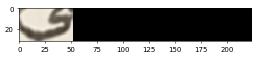

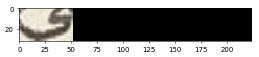

In [10]:
from random import randint
whichIm = randint(0,batch_size)
val_image = y[whichIm,:,:,:].as_in_context(mx.cpu())
val_image = val_image.transpose((1, 2, 0)) * nd.array((0.229, 0.224, 0.225)) + nd.array((0.485, 0.456, 0.406))
val_image = (val_image * 255).clip(0, 255)
val_image = val_image.asnumpy()
val_image = val_image.astype(np.uint8)
plt.rcParams["figure.dpi"] = 50
plt.imshow(val_image)
plt.savefig('/home/mcy/Dropbox/val.png')
plt.show();
org = x[whichIm,:,:,:].as_in_context(mx.cpu())
org = org.transpose((1, 2, 0)) * nd.array((0.229, 0.224, 0.225)) + nd.array((0.485, 0.456, 0.406))
org = (org * 255).clip(0, 255)
org = org.asnumpy()
org = org.astype(np.uint8)
plt.imshow(org)
plt.savefig('/home/mcy/Dropbox/org.png')
plt.show()